In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import nifgen
import niscope
from nifgen import enums
from niscope import enums as scope_enums
import numpy as np
from BEWaveform import BE_Spectroscopy, BE_Viz

# options = {'simulate': False, 'driver_setup': {'Model': '5433 (2CH)', 'BoardType': 'PXIe', }, }

fgen = nifgen.Session(resource_name='Dev1')
fgen.abort()

out = BE_Spectroscopy(16, 1, 
        wave= "chirp", 
        BE_smoothing=125, 
        start = 0,
        center_freq = 346e3,
        max = 10,
        min = -10,
        cycles = 2,
        points_per_cycle = 64, 
        phase_shift = 0,
        measurement_state_offset = 0,
)
#waveform = out.BE_wave
waveform = out.cantilever_excitation_waveform/16
# generate a WAVEFORM
sample_rate = out.AO_rate


# prepare the scope to be triggered with the exported trigger from the FGEN
scope = niscope.Session(resource_name='PXI1Slot3_2')
scope.channels[0].configure_vertical(range=4, coupling=niscope.VerticalCoupling.DC)
scope.channels[1].configure_vertical(range=1, coupling=niscope.VerticalCoupling.DC)
scope.configure_trigger_digital("PXI_Trig0", slope=scope_enums.TriggerSlope.POSITIVE)
scope.configure_horizontal_timing(min_sample_rate=int(sample_rate), min_num_pts=15000000,
                                         ref_position=0, num_records=1, enforce_realtime=True)
scope.configure_vertical(10, coupling=niscope.VerticalCoupling.DC)
scope.initiate()


fgen.output_mode = nifgen.OutputMode.ARB
fgen.arb_sample_rate = out.AO_rate
fgen.channels[0].trigger_mode = enums.TriggerMode.SINGLE
# nifgen.AnalogPath.FIXED_HIGH_GAIN
fgen.analog_path = nifgen.AnalogPath.FIXED_HIGH_GAIN

#fgen.channels[0].trigger_mode = enums.TriggerMode.CONTINUOUS
waveform_handle = fgen.create_waveform(waveform_data_array=waveform)

fgen.exported_start_trigger_output_terminal = "PXI_Trig0"

fgen.arb_waveform_handle = waveform_handle
# fgen.streaming_waveform_handle = waveform_handle
fgen.channels[0].configure_arb_waveform(waveform_handle=waveform_handle, gain=4, offset=0)

fgen.initiate()

import time

time.sleep(1)

while fgen.is_done() is False:
    pass



0
Number of samples acquired: 15,258,790



In [3]:
out.waveform_time*sample_rate*4*64

16777216.0

In [4]:
2**16

65536

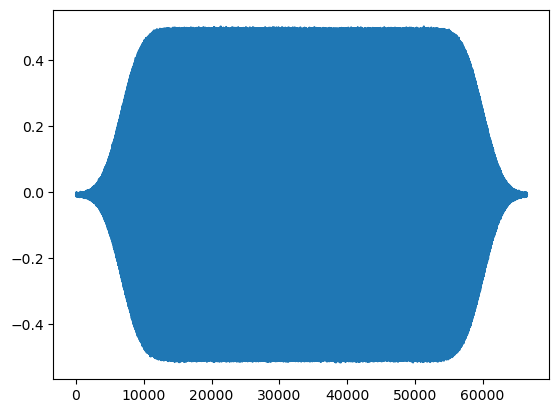

In [5]:
import matplotlib.pyplot as plt

plt.plot(wfm[0:2**16+1000])

In [6]:
out.AO_rate

16384000.0

In [7]:
viz = BE_Viz(out)

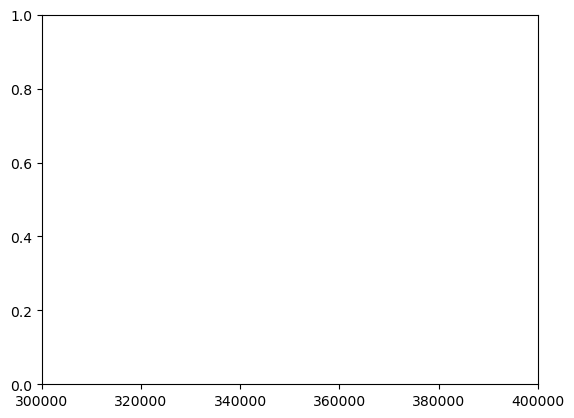

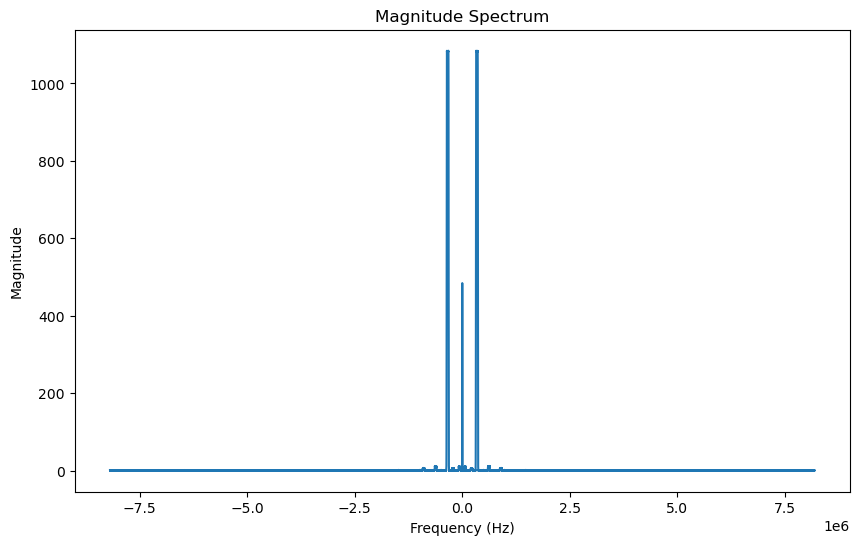

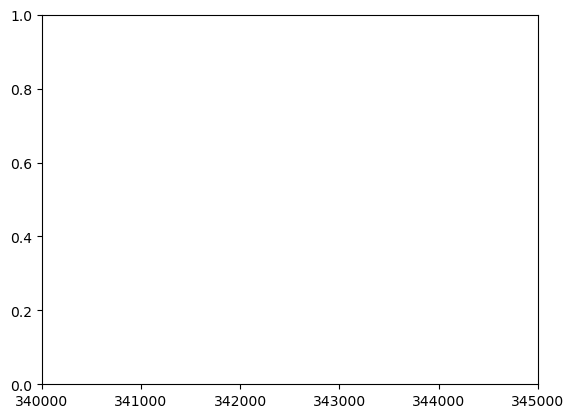

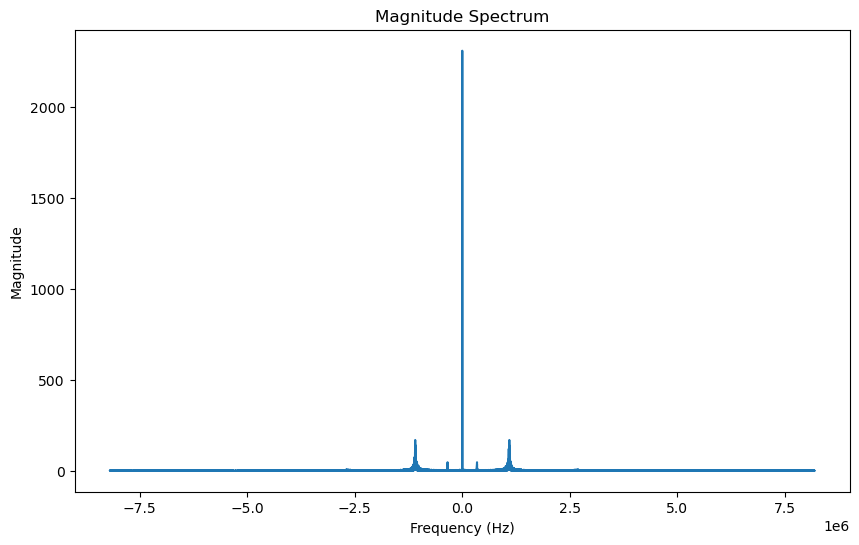

In [11]:
viz.plot_fft(wfm[0:65536], x_range = (300e3,400e3))
viz.plot_fft(response[0:65536],  x_range = (340e3,345e3))

In [ ]:
fgen.analog_path

<AnalogPath.FIXED_HIGH_GAIN: 3>